# A record of generation variables for different models in the database folder
Note that this uses a previous iteration of sedimentation that generated thicknesses and values at run time, rather than using a pre-generated list. This has been refactored to be more deterministic and reproducible.

In [1]:
import numpy as np
import pyvista as pv

import structgeo.model as geo
import structgeo.plot as geovis
import structgeo.probability as rv

pv.set_jupyter_backend('client')

## Goal:
Make an interaface that will present generated models with a yes/no decision to save the model

In [2]:
# Set random seed for reproducibility
# random_seed = 1234
# np.random.seed(random_seed)


In [3]:
from structgeo.filemanagement import FileManager

# Display the last saved model
fm = FileManager("../database/sedimentary_plane")
models = fm.load_all_models()
model = models[-2]
sed = model.history[1]
print(sed)
print(sed.base)
model.compute_model()
geovis.volview(model).show(window_size=[600, 400])



Processing models in ../database/sedimentary_plane
Sedimentation: rock type values [2, 3, 4...], and thicknesses 2.012, 1.237, 0.879..., with base = nan
nan


Widget(value='<iframe src="http://localhost:64547/index.html?ui=P_0x2a5c0ae57d0_0&reconnect=auto" class="pyvis…

## Sedimentary Plane

In [4]:
from structgeo.plot import ModelReviewer

DEFAULT_BASE_DIR = "../database/sedimentary_plane"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

def generate_model():
    # Place the model generation logic here
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    
    layer_builder = geo.SedimentBuilder(start_value = 2, total_thickness=7.5, min_layers= 3, max_layers=10)
    
    bedrock = geo.Bedrock(base, 0)
    sediment = geo.Sedimentation(*layer_builder.get_layers())
    
    # Add micro fold noise to the model
    def fold_params():
        wave_generator = rv.FourierWaveGenerator(num_harmonics=5, smoothness=.8)
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .08),
            'periodic_func': wave_generator.generate()
        }
    sediment_noise = [geo.Fold(**fold_params()) for _ in range(np.random.randint(3, 7))]
    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(30, 60),
            'amplitude': np.random.uniform(1.2),
            'periodic_func': None,
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]

    model.clear_history()
    model.add_history([bedrock, sediment] + sediment_noise + geo_noise)
    model.compute_model()
    return model


reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Model created with bounds (-10, 10) and resolution 128


Output()

# Sedimentary Plane with Dikes

In [5]:
from structgeo.plot import ModelReviewer

DEFAULT_BASE_DIR = "../database/sedimentary_plane_dikes"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

def generate_model():
    # Place the model generation logic here
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)

    layer_builder = geo.SedimentBuilder(start_value = 2, total_thickness=7.5, min_layers= 3, max_layers=10)
    
    bedrock = geo.Bedrock(base, 0)
    sediment = geo.Sedimentation(*layer_builder.get_layers())
    
    # Add micro fold noise to the model
    def fold_params():
        wave_generator = rv.FourierWaveGenerator(num_harmonics=5, smoothness=.8)
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .08),
            'periodic_func': wave_generator.generate()
        }
    sediment_noise = [geo.Fold(**fold_params()) for _ in range(np.random.randint(3, 7))]
    
    # Recover the last layer of rock
    last_val = layer_builder.get_last_value()

    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(30, 60),
            'amplitude': np.random.uniform(1.2),
            'periodic_func': None,
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]


    n_dikes = 2
    dike_rock_val = last_val+1
    def dike_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.normal(90, 25),
            'width': np.random.uniform(.05, 1),
            'origin': rv.random_point_in_ellipsoid(model.bounds),
            'value': dike_rock_val
        }
    params = dike_params()
    dike1 = geo.Dike(**params)
    
    noise_std = {
    'strike': 5,  # Noise standard deviation for 'strike'
    'dip': 5,     # Noise standard deviation for 'dip'
    'width': 0.4,  # Noise standard deviation for 'width'
    'origin': 1    # Noise standard deviation for 'origin'
}
    
    additional_dikes = []
    for i in range(n_dikes-1):
        width = params['width']
        dike_gap = (i+1)*(np.random.lognormal(.5, .5))
        strike_radians = np.deg2rad(params['strike'])
        print(f"Strike: {params['strike']}")
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0]) * dike_gap
        print(f"Gap direction: {gap_dir}")
        params['origin'] += gap_dir
        params['width'] += np.random.normal(0, noise_std['width'])
        params['strike'] += np.random.normal(0, noise_std['strike'])
        params['dip'] += np.random.normal(0, noise_std['dip'])
        # params['value'] += 1
        additional_dikes.append(geo.Dike(**params))
    
    model.clear_history()    
    model.add_history([bedrock] + [sediment] + sediment_noise + geo_noise  + [dike1]+ additional_dikes )
    model.compute_model()
    return model

Model created with bounds (-10, 10) and resolution 128


In [6]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Strike: 311.73671272968664
Gap direction: [0.900466 1.009358 0.      ]


Output()

### Tilted Sedimentary Planes, with and without Dikes

In [7]:
from structgeo.plot import ModelReviewer

DEFAULT_BASE_DIR = "../database/tilted_sedimentary_plane_vardikes"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")


def generate_model():
    # Place the model generation logic here
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)

    layer_builder = geo.SedimentBuilder(start_value = 2, total_thickness=7.5, min_layers= 3, max_layers=10)
    
    bedrock = geo.Bedrock(base, 0)
    sediment = geo.Sedimentation(*layer_builder.get_layers())
    
    # Add micro fold noise to the model
    def fold_params():
        wave_generator = rv.FourierWaveGenerator(num_harmonics=5, smoothness=.8)
        return {            
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .08),
            'periodic_func': wave_generator.generate()
        }
    sediment_noise = [geo.Fold(**fold_params()) for _ in range(np.random.randint(3, 7))]
    
    # Recover the last layer of rock
    last_val = layer_builder.get_last_value()

    # Add macro fold noise to the model
    def fold_params2():
        wave_generator = rv.FourierWaveGenerator(num_harmonics=5, smoothness=1)
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(15, 60),
            'amplitude': np.random.uniform(4),
            'periodic_func': wave_generator.generate(),
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]

    n_dikes = 4
    dike_rock_val = last_val+1
    def dike_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.normal(90, 25),
            'width': np.random.uniform(.05, 1),
            'origin': rv.random_point_in_ellipsoid(model.bounds),
            'value': dike_rock_val
        }
    params = dike_params()
    
    dike1 = [geo.Dike(**params)] if n_dikes > 0 else []

    noise_std = {
    'strike': 5,  # Noise standard deviation for 'strike'
    'dip': 5,     # Noise standard deviation for 'dip'
    'width': 0.4,  # Noise standard deviation for 'width'
    'origin': 1    # Noise standard deviation for 'origin'
}
    
    additional_dikes = []
    for i in range(n_dikes-1):
        dike_gap = (i+1)*(np.random.lognormal(.5, .5))
        strike_radians = np.deg2rad(params['strike'])
        print(f"Strike: {params['strike']}")
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0]) * dike_gap
        print(f"Gap direction: {gap_dir}")
        params['origin'] += gap_dir
        params['width'] += np.random.normal(0, noise_std['width'])
        params['strike'] += np.random.normal(0, noise_std['strike'])
        params['dip'] += np.random.normal(0, noise_std['dip'])
        # params['value'] += 1
        additional_dikes.append(geo.Dike(**params))
     
    tilt_params = {
        'strike': np.random.uniform(0, 360),
        'dip': np.random.uniform(0, 30),
    }    
    tilt = geo.Tilt(**tilt_params)
    
    model.clear_history()    
    model.add_history([bedrock]+ dike1+ additional_dikes + [sediment] +  sediment_noise + geo_noise + [tilt] )
    model.compute_model()
    return model

Model created with bounds (-10, 10) and resolution 128


In [8]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Strike: 95.47994666078436
Gap direction: [-0.22831583 -2.37988096  0.        ]
Strike: 95.44869021902694
Gap direction: [-0.25340865 -2.65668453  0.        ]
Strike: 98.46369022208077
Gap direction: [-0.78764369 -5.29319117  0.        ]


Output()

### Second Sedimentation

In [9]:
from structgeo.plot import ModelReviewer

DEFAULT_BASE_DIR = "../database/second_sedimenation"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

# Start rock vals from 5 to give space for adding dikes without knowing sedimentation values
def generate_model():
    # Place the model generation logic here
    base = min_x + np.random.normal(1, 1)
    height = 2 + np.random.normal(1, 1)    
    layer_builder = geo.SedimentBuilder(start_value = 5, total_thickness=height, min_layers= 4, max_layers=10)
    
    next_rock_val = 0

    bedrock = geo.Bedrock(base, next_rock_val)
    sediment = geo.Sedimentation(*layer_builder.get_layers())

    next_rock_val = layer_builder.get_last_value() + 1
    
    # Add micro fold noise to the model
    def noise_fold_params():
        wave_generator = rv.FourierWaveGenerator(num_harmonics=5, smoothness=.8)
        return {            
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(.5, 10),
            'amplitude': np.random.uniform(.04, .08),
            'periodic_func': wave_generator.generate()
        }
    sediment_noise = [geo.Fold(**noise_fold_params()) for _ in range(np.random.randint(3, 7))]
    
    # Add macro fold noise to the model
    def fold_params2():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.uniform(0, 360),
            'rake': np.random.uniform(0, 360),
            'period': np.random.uniform(10, 60),
            'amplitude': np.random.uniform(.1,2),
            'periodic_func': None,
            'shape': np.random.uniform(0, 2)
        }
    geo_noise = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]
    
    tilt_params = {
        'strike': np.random.uniform(0, 360),
        'dip': np.random.uniform(0, 30),
    }    
    tilt = geo.Tilt(**tilt_params)
    
    # Second Sedimentation
    base = min_x + model_size*np.clip(np.random.normal(.15, .2), -.25, .35)
    height = min_x + model_size/2 + np.random.normal(1, model_size / 8)
    height = max(height, base + model_size/10)
        
    layer_builder2 = geo.SedimentBuilder(start_value = next_rock_val, total_thickness=height-base, min_layers= 4, max_layers=10)
    
    sediment2 = geo.Sedimentation(*layer_builder2.get_layers()) 
    next_rock_val = layer_builder2.get_last_value() + 1  
        
    sediment_noise2 = [geo.Fold(**noise_fold_params()) for _ in range(np.random.randint(3, 4))]
    geo_noise2 = [geo.Fold(**fold_params2()) for _ in range(np.random.randint(1, 3))]
    
    # Start at 0 
    dike_rock_val = next_rock_val
    def dike_params():
        return {
            'strike': np.random.uniform(0, 360),
            'dip': np.random.normal(90, 25),
            'width': np.random.uniform(.5, 1),
            'origin': rv.random_point_in_ellipsoid(model.bounds),
            'value': dike_rock_val
        }
        
    noise_std = {
    'strike': 5,  # Noise standard deviation for 'strike'
    'dip': 5,     # Noise standard deviation for 'dip'
    'width': 0.4,  # Noise standard deviation for 'width'
    'origin': 1    # Noise standard deviation for 'origin'
}   
    
    n_dikes = 3
    params = dike_params()
    dikes = []    
    for i in range(n_dikes):
        width = params['width']
        dike_gap = (i)*(np.random.lognormal(.5, .5))
        strike_radians = np.deg2rad(params['strike'])
        print(f"Strike: {params['strike']}")
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0]) * dike_gap
        print(f"Gap direction: {gap_dir}")
        params['origin'] += gap_dir
        params['width'] += np.random.normal(0, noise_std['width'])
        params['strike'] += np.random.normal(0, noise_std['strike'])
        params['dip'] += np.random.normal(0, noise_std['dip'])
        # params['value'] += 1
        dikes.append(geo.Dike(**params))

    model.clear_history()
    model.add_history([bedrock, sediment]  + geo_noise + [tilt] + [sediment2] + geo_noise2 + dikes + sediment_noise2 )

    model.compute_model()
    return model


Model created with bounds (-10, 10) and resolution 128


In [10]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Strike: 286.1612726762948
Gap direction: [0. 0. 0.]
Strike: 289.5835183924192
Gap direction: [0.52997765 1.48970604 0.        ]
Strike: 288.2313193252859
Gap direction: [1.77066179 5.37559325 0.        ]


Output()

In [11]:
import numpy as np
import pyvista as pv
import copy
import itertools

import structgeo.model as geo
import structgeo.plot as geovis
import structgeo.probability as rv
from structgeo.filemanagement import FileManager
from structgeo.plot import ModelReviewer


LOAD_FOLDER = "../database"
DEFAULT_BASE_DIR = "../augmented_sediment_models"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)
print(f"Model created with bounds {bounds} and resolution {resolution}")

# Load an existing model from file
models = FileManager(LOAD_FOLDER).load_all_models()
    # Select a random model from the loaded models and make a deep copy
model_cycler = itertools.cycle(models[170:-1])

def generate_model():

    model = copy.deepcopy(next(model_cycler))
    rotation_axis = (np.random.uniform(0,.15) ,np.random.uniform(0,.15),1)
    rotation_amount = np.random.uniform(0, 360)
    rotate = geo.Rotate(rotation_axis, rotation_amount)
    # make a random 3D shift vector
    shift_vector = (np.random.normal(0,3), np.random.normal(0,3), np.random.normal(0,3))
    shift = geo.Shift(shift_vector)
    model.add_history([rotate, shift])
    model.compute_model()
    bounds = model.get_z_bounds()
    zmin, zmax = bounds
    z_range = zmax - zmin
    target_height = zmin + z_range*np.random.normal(.8, .05)    
    print(f"Target height: {target_height}")
    model.renormalize_height(target_height)
    return model

model = generate_model()


Model created with bounds (-10, 10) and resolution 128
Processing models in ../database
Target height: 7.215827996391333


In [12]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Target height: 5.9773274816520345


Output()

# Add fault/ shear/ slip

Processing models in ../database
(0, 0, 0, 0)


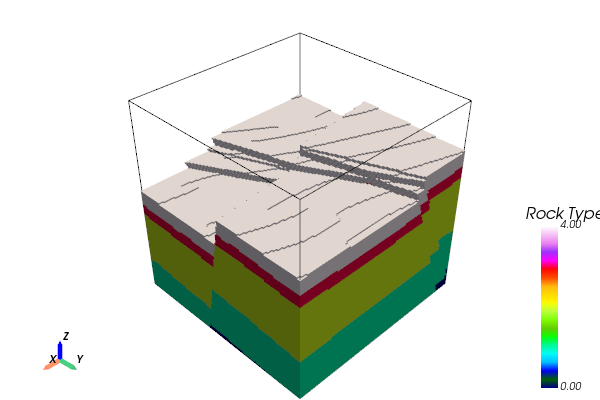

In [13]:
import numpy as np
import pyvista as pv
import copy

import structgeo.model as geo
import structgeo.plot as geovis
import structgeo.probability as rv
from structgeo.filemanagement import FileManager
from structgeo.plot import ModelReviewer
pv.set_jupyter_backend('static')

LOAD_FOLDER = "../database"
DEFAULT_BASE_DIR = "../sheared_models"

# Start with some model specifications
resolution = 128
# Cubic model keeps 
max_x = 10
min_x = - max_x
model_size = max_x - min_x
bounds = (min_x,max_x)
model = geo.GeoModel(bounds, resolution)

# Load an existing model from file
models = FileManager(LOAD_FOLDER).load_all_models()

# Single model loader
#models = FileManager("../faulted_models").load_all_models()

# Select a random model from the loaded models and make a deep copy
model = np.random.choice(models)
demo_model = models

def get_history():
    """ Make an appended slip based history to add"""

    def fault_sequence(n_faults):
        # Random fault line
        strike = np.random.uniform(0, 360)
        dip = np.random.normal(80,20)
        rake = np.random.uniform(0, 180)
        amplitude = np.random.normal(.2,.3)
        origin = rv.random_point_in_ellipsoid(model.bounds)    
        strike_radians = np.deg2rad(strike)
        gap_dir = np.array([np.cos(strike_radians), -np.sin(strike_radians), 0])
        
        def parameters():
            params = {
            'strike': strike + np.random.normal(0, 5),
            'dip': dip + np.random.normal(0, 5),
            'rake': rake + np.random.uniform(0, 7),
            'amplitude': amplitude + np.random.normal(0, .2),
            # 'steepness': np.random.normal(3,1),
            'origin': origin + np.random.normal(.2, .2)*gap_dir,
        }
            return params
    
        faults = []
        for _ in range(n_faults):
            params = parameters()
            faults.append(geo.Fault(**params))            
        return faults
    
    n_faults = 3
    return fault_sequence(n_faults)

def generate_model():
    # Select a random model from the loaded models and make a deep copy
    demo_model = np.random.choice(models)
    model = copy.deepcopy(demo_model)   
    
    # Shuffle the view a bit
    rotation_axis = (np.random.uniform(0,.05) ,np.random.uniform(0,.05),1)
    rotation_amount = np.random.uniform(0, 360)
    rotate = geo.Rotate(rotation_axis, rotation_amount)
    shift_vector = (np.random.normal(0,1), np.random.normal(0,1), np.random.normal(0,1))
    shift = geo.Shift(shift_vector)
    model.add_history([rotate, shift])
    
    # Add some fault history
    model.add_history(get_history())
    model.compute_model()
    model.renormalize_height(auto = True)
    return model

model = generate_model()
print(np.shape(model.snapshots))

geovis.volview(model).show(window_size=[600, 400])
geovis.transformationview(model)

In [14]:
reviewer = ModelReviewer(generate_model_func=generate_model, base_dir=DEFAULT_BASE_DIR)
reviewer.start_review()

Output()